In [3]:
import pystan
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline
import pystan
import datetime
sns.set()

In [7]:
df=pd.read_csv('data/train.csv')
df.columns=['Id', 'Province_State', 'region', 'date', 'cases','fatalities']
df.date=pd.to_datetime(df.date)
df.head()

,Id,Province_State,region,date,cases,fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [50]:
model_logistic = """
data {
    int<lower=1> n;
    int<lower=1> n_pred;
    vector[n] y;
    vector[n] t;
    vector[n_pred] t_pred;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> t0;
    real<lower=0> sigma; 
}
model {
alpha~normal(1,1);
beta~normal(1,1);
t0~normal(10,10);
y ~ normal(alpha ./ (1 + exp(-(beta*(t-t0)))), sigma);
}
generated quantities {
  vector[n_pred] pred;
  for (i in 1:n_pred)
  pred[i] = normal_rng(alpha / (1 + exp(-(beta*(t_pred[i]-t0)))),sigma);
}
"""
stan_model= pystan.StanModel(model_code=model_logistic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b949d3c84e35edd2dccd977a423d8b0 NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/16/01w8_c7d29dfb6zzz2l20sr04r07j1/T/tmpfezjk6li/stanfit4anon_model_7b949d3c84e35edd2dccd977a423d8b0_7965472348759715338.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [51]:
country_list=['China','US','Italy','Italy','Spain','Iran','Germany','France']
df=df[df.region.isin(country_list)]
n_days=25
country_v='France'
target_var='cases'
region_var='region'
target_var_norm_coef=1/100000
time_var_norm_coef=1/7
df_ts=df.set_index('date').groupby([pd.Grouper(freq='D'),region_var])[target_var].sum()\
.to_frame('sum').reset_index().pivot('date',region_var,'sum')
df1=df_ts[[country_v]]
df1.columns=['y']
print ('size:',df_ts_p.shape[0])
df1.reset_index(inplace=True)
n_train=df1.shape[0]
maxdate=df1.date.max()
for i in np.arange(1,n_days+1):
    df1=df1.append(pd.DataFrame({'date':[maxdate+datetime.timedelta(days=int(i))]}))
df1['ndate']=np.arange(df1.shape[0])
df1.set_index('date',inplace=True)
df1.y=target_var_norm_coef*df1.y
df1['t']=time_var_norm_coef*df1.ndate

data = {'n': n_train,'n_pred':df1.shape[0],
        'y': df1.iloc[:n_train,:].y.values,'t':df1.iloc[:n_train,:].t.values,'t_pred':df1.t.values}

fit=stan_model.sampling(data=data, iter=5000, chains=3)

fit_samples = fit.extract(permuted=True)
pred=fit_samples['pred']
df1['pred']=pred.mean(axis=0)
df1['pred_yerr']=(pd.DataFrame(pred).quantile(q=0.95,axis=0).values-\
                   pd.DataFrame(pred).quantile(q=0.05,axis=0).values)/2

size: 66


Model parameters: alpha=0.724 (sd:0.043, beta=1.408(sd:0.028),t0=9.406(sd:0.074)


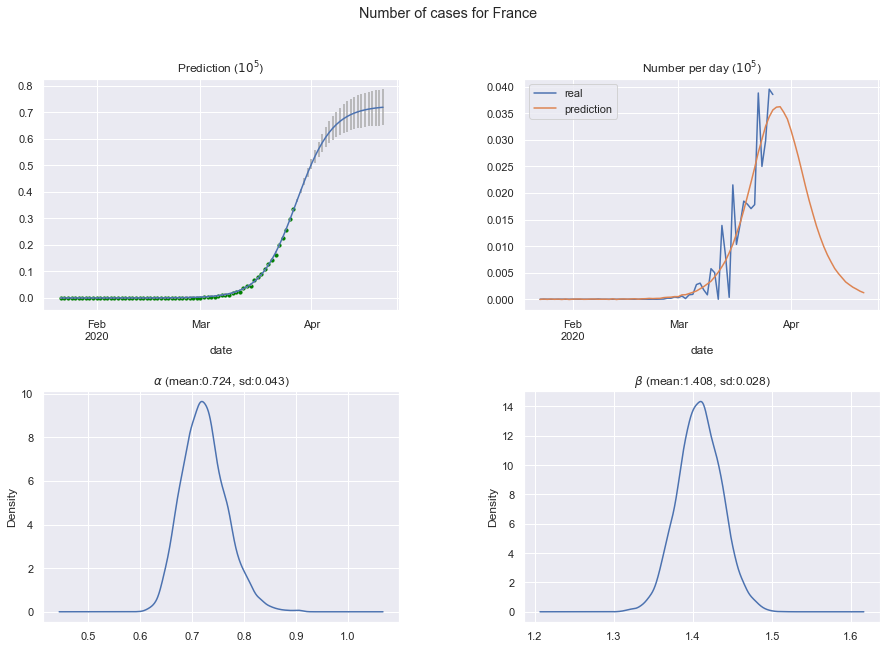

In [52]:
fig, ax = plt.subplots(2,2, sharex=False, figsize=(15,10))
fig.subplots_adjust(hspace=0.35, wspace=0.35)
df1['pred'].plot(yerr=df1['pred_yerr'].values,title='Prediction ($10^5$)',ecolor='#aaaaaa',ax=ax[0,0])
ax[0,0].scatter(df1.index,df1.y,s=10,c='green')
df1[['n_per_day_real','n_per_day_prediction']]=df1[['y','pred']]-df1[['y','pred']].shift(1)
df1[['n_per_day_real','n_per_day_prediction']].plot(ax = ax[0,1],title='Number per day ($10^5$)')
alpha_mean=np.round(fit_samples['alpha'].mean(),3)
alpha_std=np.round(fit_samples['alpha'].std(),3)
beta_mean=np.round(fit_samples['beta'].mean(),3)
beta_std=np.round(fit_samples['beta'].std(),3)
t0_mean=np.round(fit_samples['t0'].mean(),3)
t0_std=np.round(fit_samples['t0'].std(),3)
print (f'Model parameters: alpha={alpha_mean} (sd:{alpha_std}, beta={beta_mean}(sd:{beta_std}),\
t0={t0_mean}(sd:{t0_std})')
alpha_samples=np.round(pd.Series(fit_samples['alpha']),3)
alpha_samples.plot(kind='density', 
title=r'$\alpha$'+f' (mean:{alpha_mean}, sd:{alpha_std})',ax = ax[1,0])
beta_samples=pd.Series(fit_samples['beta'])
beta_samples.plot(kind='density', 
title=r'$\beta$'+f' (mean:{beta_mean}, sd:{beta_std})',ax = ax[1,1])
fig.suptitle(f'Number of {target_var} for {country_v}')
plt.savefig('p1.png', dpi=150,bbox_inches='tight')
plt.show()

In [53]:
df1

,y,ndate,t,pred,pred_yerr,real,prediction
date,,,,,,,
2020-01-22,0.00000,0,0.000000,3.182926e-06,0.004056,NaN,NaN
2020-01-23,0.00000,1,0.142857,-3.330896e-05,0.004122,0.00000,-0.000036
2020-01-24,0.00002,2,0.285714,-2.660682e-07,0.004079,0.00002,0.000033
2020-01-25,0.00003,3,0.428571,-2.525988e-05,0.004026,0.00001,-0.000025
2020-01-26,0.00003,4,0.571429,1.878232e-05,0.004032,0.00000,0.000044
2020-01-27,0.00003,5,0.714286,3.358017e-06,0.004060,0.00000,-0.000015
2020-01-28,0.00004,6,0.857143,2.433563e-05,0.004128,0.00001,0.000021
2020-01-29,0.00005,7,1.000000,-1.975782e-05,0.004039,0.00001,-0.000044
2020-01-30,0.00005,8,1.142857,2.136555e-05,0.004094,0.00000,0.000041


In [ ]:
country_list=['China','US','Italy','Spain','Iran','Germany','France']
target_var='cases'
beta_df=pd.DataFrame()
for i in country_list:
    fit_samples=get_pred(df_c, parameters={'t0':(-5,3),'beta':(1,0.5),'alpha':(1,1)},
         country_v=i,target_var=target_var, filename='imgs/'+target_var+'_'+i+'.png')
    beta_df1=pd.DataFrame(fit_samples['beta'],columns=['beta'])
    beta_df1['country']=i
    beta_df=beta_df.append(beta_df1)